### Импорт необходимых библиотек и модулей

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 16)
%matplotlib inline

### Загрузка данных

In [54]:
data = pd.read_csv('site_revenue_data.csv')
data.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


Работать с capse-named колонками не очень удобно, поэтому переименуем их:

In [55]:
data.rename(columns={'USER_ID': 'user_id', 'VARIANT_NAME': 'variant_name', 'REVENUE': 'revenue'}, 
            inplace=True)
data.head()

,user_id,variant_name,revenue
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


### Чистка и трансформация данных

Посмотрим краткую информацию о датасете:

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       10000 non-null  int64  
 1   variant_name  10000 non-null  object 
 2   revenue       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [57]:
print(f'количество строк в датафрейме: {data.shape[0]}')

количество строк в датафрейме: 10000


Так как в датафрейме в целом 10к строк и в каждом из столбцов 10к non-null значений, то заниматься заполнением/удалением пропусков ненужно, в этом плане все ОК

Посмотрим, насколько вариативны значения по столбцам:

In [58]:
data.nunique()

user_id         6324
variant_name       2
revenue          101
dtype: int64

С `variant_name` все ОК, у нас две группы - контрольная и тестовая, поэтому уникальных значений тоже 2


С `revenue` тоже все OK, ничего необычного в плане количества уникальных значений нет


С `user_id` интереснее: уникальных пользователей 6324, а записей в в датафрейме 10000. Значит, некоторые пользователи встречаются в таблице несколько раз. Поэтому нужно сделать группировку по `user_id` и агрегацию по `revenue`

#### Группируем данные по пользователям

Для начала проверим, что каждый пользователь принадлежит только одной группе `variant_name`. Это нужно, во-первых, для правильной агрегации по `revenue`, а во-вторых, необходимо на этапе анализа результатов a/b теста и проверки гипотез

In [59]:
control_users = set(data[data['variant_name'] == 'control']['user_id'])
variant_users = set(data[data['variant_name'] == 'variant']['user_id'])
overlapping_users = control_users & variant_users
print(f'количество пересекающихся клиентов: {len(overlapping_users)}')

количество пересекающихся клиентов: 1541


Видим, что группы пересекаются. Нам необходимо исключить таких клиентов из нашей выборки:

In [60]:
data = data[data['user_id'].map(lambda id: id not in overlapping_users)]
data

,user_id,variant_name,revenue
0,737,variant,0.0
4,6174,variant,0.0
5,2380,variant,0.0
7,9168,control,0.0
9,7548,control,0.0
...,...,...,...
9993,2400,variant,0.0
9994,3129,control,0.0
9996,502,variant,0.0
9998,7741,control,0.0


Делаем группировку по  `user_id` и считаем суммарную выручку для каждого пользователя:

In [61]:
data = data.groupby(by=['user_id', 'variant_name'], as_index=False)['revenue'].aggregate(sum)
data

,user_id,variant_name,revenue
0,2,control,0.0
1,4,variant,0.0
2,5,variant,0.0
3,6,variant,0.0
4,9,variant,0.0
...,...,...,...
4778,9990,variant,0.0
4779,9992,control,0.0
4780,9993,control,0.0
4781,9995,variant,0.0


Теперь наши данные очищены и подготовлены для анализа

### Анализ данных

### Посмотрим размеры групп

In [62]:
data.groupby(by='variant_name').size()

variant_name
control    2390
variant    2393
dtype: int64

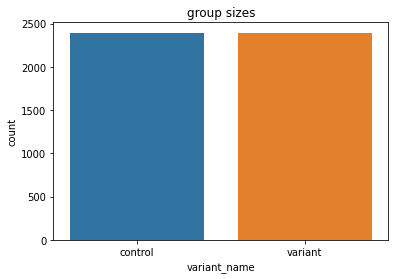

In [63]:
sns.countplot(x=data['variant_name']).set_title('group sizes')
plt.show()

In [64]:
px.box(x=data['variant_name'], y=data['revenue'], title='groups boxplots')

In [65]:
data.groupby(by='variant_name')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
variant_name,,,,,,,,
control,2390.0,0.196887,4.172201,0.0,0.0,0.0,0.0,196.01
variant,2393.0,0.074935,0.858207,0.0,0.0,0.0,0.0,23.04


([<matplotlib.axis.XTick at 0x7f7144a07b80>,
 [Text(-25.0, 0, '−25'),
  Text(0.0, 0, '0'),
  Text(25.0, 0, '25'),
  Text(50.0, 0, '50'),
  Text(75.0, 0, '75'),
  Text(100.0, 0, '100'),
  Text(125.0, 0, '125'),
  Text(150.0, 0, '150'),
  Text(175.0, 0, '175'),
  Text(200.0, 0, '200'),
  Text(225.0, 0, '225'),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

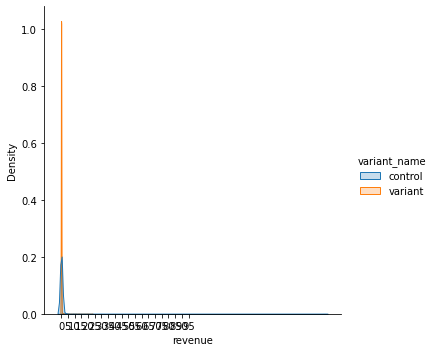

In [68]:
sns.displot(data, x='revenue', hue='variant_name', kind="kde", fill=True)
plt.xticks(np.arange(0, 100, 5))